# Challenge 3: Understanding user and product interaction
- Author: Ali Mohammadi
- Email: mohammadi.aliakbar@gmail.com
- Tel: 0431371072

In [11]:
import pandas as pd
from pandas.io.json import json_normalize
import json
from itertools import combinations
import numpy as np
from tqdm import tqdm
from requests import get

%matplotlib inline

## Loading JSON file into a data frame

In [12]:
with open('data/challenge_3.json') as file:
    data = json.load(file)
    for r in data:
        r['user'] = r['user'][0][0]
        r['session_id'] = r['session_id'][0]
        r['unix_timestamp'] = r['unix_timestamp'][0]
        r['cities'] = [c.strip() for c in r['cities'][0].split(',')]
#    df = json_normalize(data)
df = json_normalize(data, 'cities', [['user', 'user_id'], ['user', 'joining_date'], 
                                     ['user', 'country'], ['user', '_row'],
                                     'session_id', 'unix_timestamp'],
                    errors='ignore')
df = df.rename(columns={0: "city",})    
    
df.head()


,city,user.user_id,user.joining_date,user.country,user._row,session_id,unix_timestamp
0,New York NY,2024,2015-03-22,UK,nan,X061RFWB06K9V,1442503708
1,Newark NJ,2024,2015-03-22,UK,nan,X061RFWB06K9V,1442503708
2,New York NY,2853,2015-03-28,DE,nan,5AZ2X2A9BHH5U,1441353991
3,Jersey City NJ,2853,2015-03-28,DE,nan,5AZ2X2A9BHH5U,1441353991
4,Philadelphia PA,2853,2015-03-28,DE,nan,5AZ2X2A9BHH5U,1441353991


## There was a bug in the code and one country didn't get logged. Can you guess which country? How?
Unix timestamp of user sessions can be converted to UTC date/time. It's hour component can help us to find **user country time zone**;

In [13]:
df['UTC_date_time'] = pd.to_datetime( df['unix_timestamp'], unit='s' )
df['hour'] = df['UTC_date_time'].apply(lambda x: x.hour)
df.head()

,city,user.user_id,user.joining_date,user.country,user._row,session_id,unix_timestamp,UTC_date_time,hour
0,New York NY,2024,2015-03-22,UK,nan,X061RFWB06K9V,1442503708,2015-09-17 15:28:28,15
1,Newark NJ,2024,2015-03-22,UK,nan,X061RFWB06K9V,1442503708,2015-09-17 15:28:28,15
2,New York NY,2853,2015-03-28,DE,nan,5AZ2X2A9BHH5U,1441353991,2015-09-04 08:06:31,8
3,Jersey City NJ,2853,2015-03-28,DE,nan,5AZ2X2A9BHH5U,1441353991,2015-09-04 08:06:31,8
4,Philadelphia PA,2853,2015-03-28,DE,nan,5AZ2X2A9BHH5U,1441353991,2015-09-04 08:06:31,8


Let's study distribution of hour column for each user country:

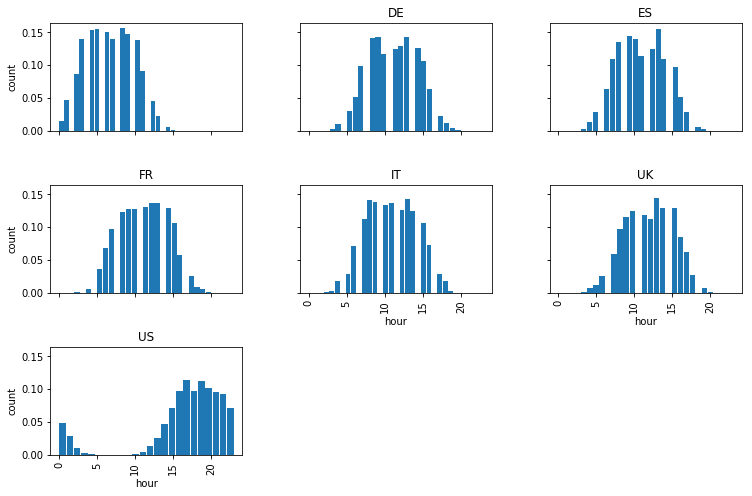

In [14]:
axarr = df.hist(column='hour', by='user.country', bins=24, density=True, figsize=(12,8), rwidth=0.9, sharex=True, sharey=True,)
for ax in axarr.flatten():
    ax.set_ylabel('count')
    ax.set_xlabel('hour')

The top left-most figure is distribution of user session hours for the unknown country. If we consider that US is a multi time zone country and distribution of hours in two consequence days, it is not a bad idea to assume bell shape of gussian distribution for session hours of all countries. UK time zone can also be assumed equal to UTC. So, we can compare mean of distributions to find countries time difference with UTC. 

Text(0, 0.5, 'Mean of session hours')

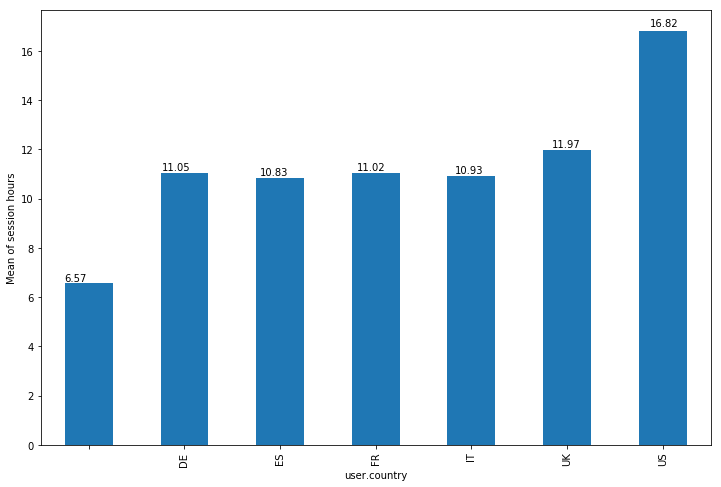

In [15]:
ax = df.groupby('user.country')['hour'].mean().plot( kind='bar', figsize=(12,8))
for p in ax.patches:
    ax.annotate(str(round(p.get_height(),2)), (p.get_x() * 1.02, p.get_height() * 1.01))
ax.set_ylabel('Mean of session hours')

So the time difference between UTC (UK) and the unknown country is:

In [16]:
unknown_country_time_difference = 11.97 - 6.57
print(unknown_country_time_difference)

5.4


<img src="time_zone_map.png">

On a time zone map as above, looking for a +5.4 time difference will lead us to somewhere around **India (IN)**. So, It is very probable that the loast country is ***India***.

# For each city, find the most likely city to be also searched for within the same session.
Let's start from co-occurrence matrix (Xcooccurrence); An square matrix that keeps number of times that  co-occurrence of city pairs have happend. It's size is number_of_cities x number_of_cities. 

In [17]:
from scipy.sparse import csr_matrix
    
cities = sorted( list( {c for d in data for c in d['cities']}) )
print(f'number of cities: {len(cities)}')

row_ind, col_ind, values = [], [], []
for i, d in enumerate(data):
    for city in d['cities']:
        row_ind.append( i )
        col_ind.append( cities.index(city) )
        values.append( 1 )
# X is a Compressed Sparse Row matrix. X size is . 
# It is len(data) x len(cities) matrix that keeps occerrence of cities in each search session.
X = csr_matrix((values, (row_ind, col_ind)), shape=( len(data), len(cities) ) )
print(f'number of sessions: {X.shape[0]}')

Xcooccurrence = (X.T * X)    
Xcooccurrence.setdiag(0)
Xcooccurrence = Xcooccurrence.todense()
print(f'co-occurrence matrix size: {Xcooccurrence.shape}')

number of cities: 89
number of sessions: 20022
co-occurrence matrix size: (89, 89)


We can normalize co-occurrence matrix if we divide elements of each row by sum of the row. So, we have probabilities of co-occurrences in Xcooccurrence_probablity as below;

In [18]:
Xcooccurrence_probablity = Xcooccurrence / Xcooccurrence.sum(axis=1)

Now, a max aggrigation over columns of Xcooccurrence_probablity will provide us with most probable pairs of city appearances in seach sessions.

In [19]:
max_list = [round(x[0,0],2) for x in Xcooccurrence_probablity.max(axis=1)]
argmax_list = [i[0,0] for i in Xcooccurrence_probablity.argmax(axis=1)]

most_prob_pairs = pd.DataFrame({'CityX': cities, 
                                'CityY': [cities[i] for i in argmax_list],
                                'Probability': max_list})
print('most probable pairs of cities in a session search:')
most_prob_pairs

most probable pairs of cities in a session search:


,CityX,CityY,Probability
0,Anaheim CA,Los Angeles CA,0.34
1,Arlington TX,Dallas TX,0.24
2,Atlanta GA,Jacksonville FL,0.44
3,Austin TX,Houston TX,0.35
4,Bakersfield CA,Los Angeles CA,0.50
5,Baltimore MD,New York NY,0.37
6,Birmingham AL,Atlanta GA,0.25
7,Boston MA,New York NY,0.31
8,Buffalo NY,Toronto ON,0.34
9,Calgary AB,Vancouver BC,0.22


## Travel sites are browsed by two kinds of users. Users who are actually planning a trip and users who just dream about a vacation. The first group obviously has a much higher purchasing intent. Users planning a trip often search for cities close to each other, while users who search for cities far away from each other are often just dreaming about a vacation (or a great work trip!). Based on this idea, come up with an algorithm that clusters sessions into two groups: high intent and low intent.
We need to collect distance between city pairs. Here, we use google map distance matrix API to collect hours and Kms between pairs of cities.

In [20]:
if 0: # one-off
    jsons = []
    for origin, destination in tqdm( combinations(cities,2) ): 
        url = "https://maps.googleapis.com/maps/api/distancematrix/json"\
                + f"?origins={origin}"\
                + f"&destinations={destination}"\
                + "&key=" # Key deleted for security reasons
        r = get(url)
        d = r.json()
        d['origin'] = origin
        d['destination'] = destination
        jsons.append(d)

    with open('city_distances__.json', 'w') as file:
        json.dump(jsons, file)

We rearrange city pairs and their google provided distance related data into a dictionary of tuples to make it easier to retreive.

In [21]:
with open('city_distances_00.json', 'r') as file:
    jsons = json.load(file)

distances = {}
for d in jsons:
    distances[(d['origin'], d['destination'])] = d

Now, we can calculate distance between city pairs searched in a user session. We use average distance (KM) and average hours as inputs of clustering algorithm. 

In [22]:
for session in data:
    distance_lst, duration_lst = [], []
    for cityX, cityY in combinations( sorted(session['cities']), 2 ):
        distance_lst.append( distances[(cityX,cityY)]['rows'][0]['elements'][0]['distance']['value'] //1000 )
        duration_lst.append( distances[(cityX,cityY)]['rows'][0]['elements'][0]['duration']['value'] // 3600 )
        
    session['avg_distance'] = np.mean(distance_lst) if len(distance_lst) else 0
    session['avg_duration'] = np.mean(duration_lst) if len(duration_lst) else 0
    
sessions = pd.DataFrame(data)

We used KMeans to cluster sessions into two cluster;

In [23]:
from sklearn.cluster import KMeans
X = sessions[['avg_distance','avg_duration']].values

kmeans = KMeans(n_clusters=2, random_state=0).fit(X)
sessions['cluster_labels'] = kmeans.labels_

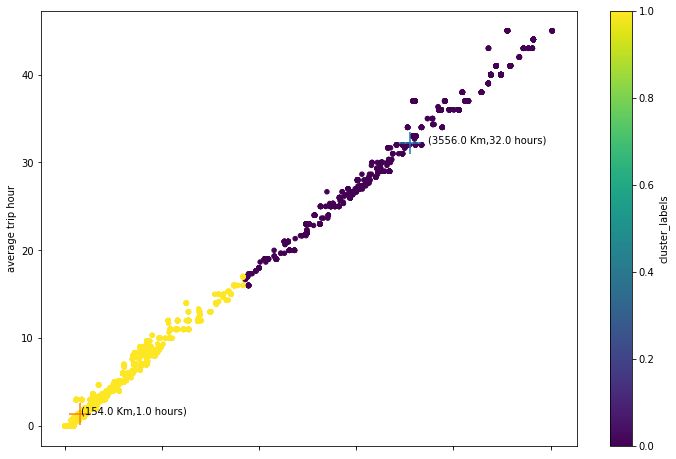

In [24]:
ax = sessions.plot('avg_distance', 'avg_duration', kind='scatter', c='cluster_labels', 
                   colormap='viridis',  figsize=(12,8))
for i, j in kmeans.cluster_centers_:
    ax.scatter(i, j, marker='+', s=500)
    ax.text(i*1.05, j, f'({i//1} Km,{j//1} hours)')
ax.set(ylabel='average trip hour', xlabel='average trip distance (km)');

So, cluster number 1 (marked as yellow dots) includes high intent users. 